# Stock Market Prediction using ARIMA and Gradient Boosting Models

## Introduction
This notebook demonstrates the process of predicting stock market prices using ARIMA for time-series analysis and Gradient Boosting for machine learning. It includes data preparation, exploratory data analysis, feature engineering, hyperparameter tuning, and model evaluation.

## Step 1: Data Preparation

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Download Data

In [2]:
# Download historical stock data for selected equities
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', group_by='ticker')

# Save data for one stock (example: AAPL)
stock_data = data['AAPL']
stock_data.reset_index(inplace=True)
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
stock_data.set_index('Date', inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


### Handle Missing Values

In [3]:
# Fill missing values
stock_data = stock_data.fillna(method='ffill')

In [4]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778677,24.789800,23.879980,24.320431,212818400
2015-01-05,24.089090,24.169172,23.448435,23.635292,257142000
2015-01-06,23.699794,23.897774,23.274914,23.637508,263188400
2015-01-07,23.846614,24.069063,23.735389,23.968962,160423600
2015-01-08,24.298183,24.947736,24.180283,24.889898,237458000


## Step 2: Exploratory Data Analysis (EDA)

### Visualize Trends

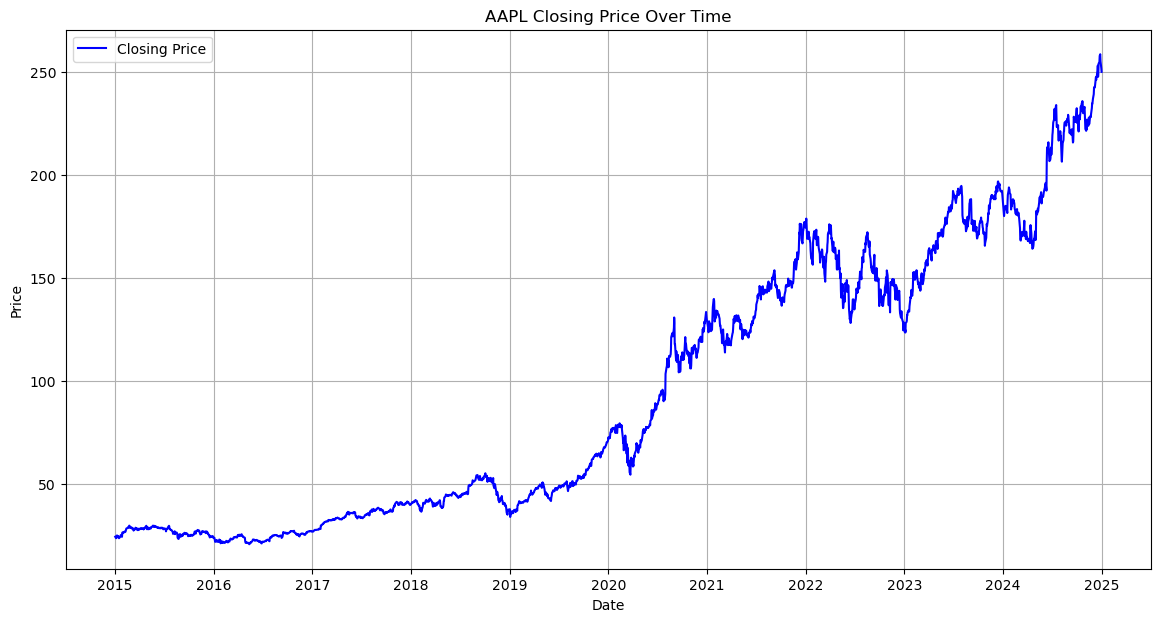

In [5]:
# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Moving Averages

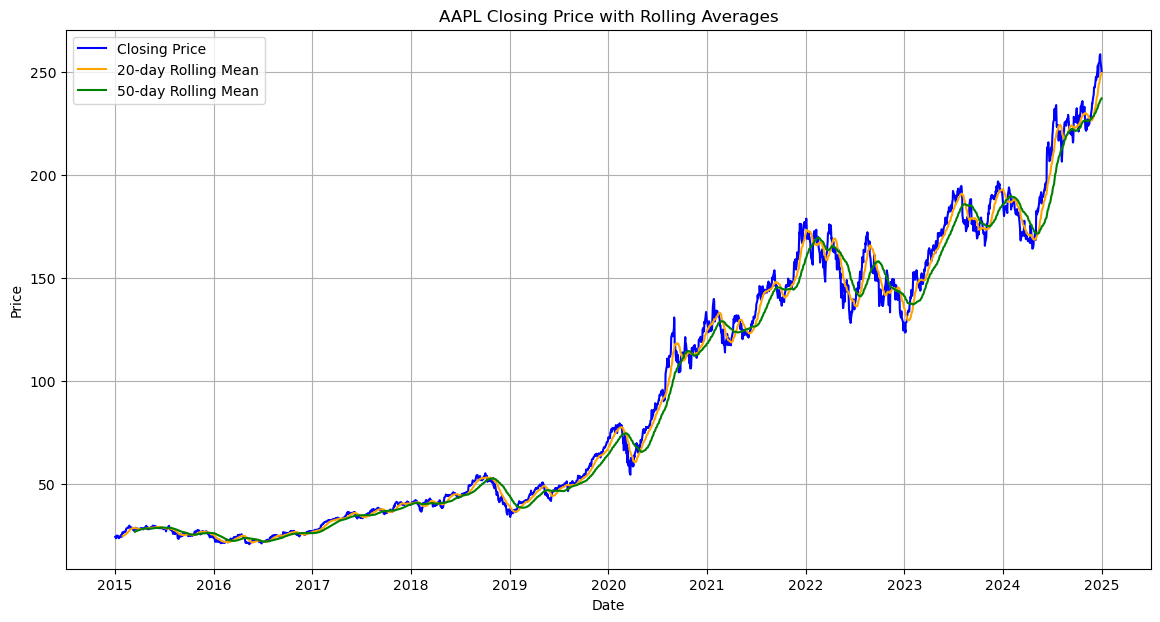

In [6]:
# Add rolling averages for visualization
stock_data['Rolling_Mean_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Rolling_Mean_50'] = stock_data['Close'].rolling(window=50).mean()

# Plot closing prices and rolling means
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.plot(stock_data['Rolling_Mean_20'], label='20-day Rolling Mean', color='orange')
plt.plot(stock_data['Rolling_Mean_50'], label='50-day Rolling Mean', color='green')
plt.title('AAPL Closing Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Visualize Volume Trends


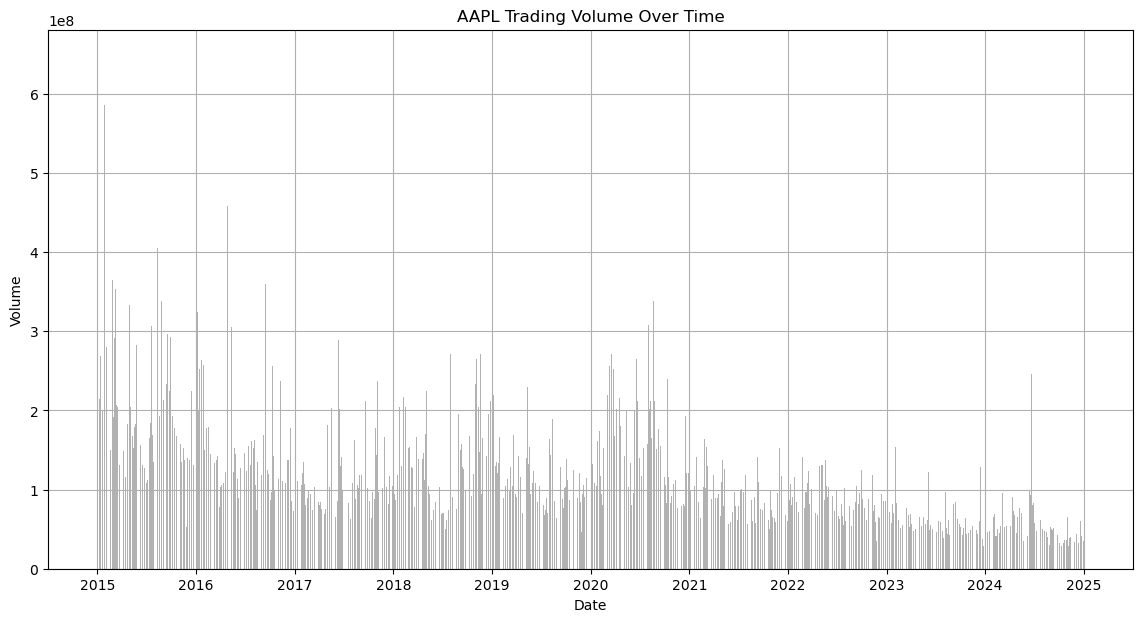

In [7]:
# Plot volume over time to analyze trading activity
plt.figure(figsize=(14, 7))
plt.bar(stock_data.index, stock_data['Volume'], color='gray', alpha=0.6)
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

## Step 3: Feature Engineering

### Create Features

In [8]:
# Create lagged features for predictive modeling (previous day's closing price)
stock_data['Lag_1_Close'] = stock_data['Close'].shift(1)

# Rolling mean of closing prices (short-term trends)
stock_data['Rolling_Mean_5'] = stock_data['Close'].rolling(window=5).mean()

# Percentage change in closing price (daily returns)
stock_data['Pct_Change_Close'] = stock_data['Close'].pct_change()

# Drop rows with NA values after feature creation
stock_data.dropna(inplace=True)

## Step 4: Modeling

### ARIMA Model with Hyperparameter Tuning

In [9]:
# Define parameter ranges for ARIMA model tuning
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq_combinations = list(itertools.product(p, d, q))

best_rmse_arima = float("inf")
best_pdq = None

# Perform grid search to find optimal ARIMA parameters
for pdq in pdq_combinations:
    try:
        model = ARIMA(stock_data['Close'], order=pdq)
        results = model.fit()
        forecast = results.forecast(steps=10)
        actual = stock_data['Close'].iloc[-10:]  # Last 10 actual values for comparison
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        if rmse < best_rmse_arima:
            best_rmse_arima = rmse
            best_pdq = pdq
    except:
        continue

print(f"Best Parameters for ARIMA: {best_pdq}")
print(f"Best ARIMA RMSE: {best_rmse_arima}")

# Fit final ARIMA model with best parameters
final_arima_model = ARIMA(stock_data['Close'], order=best_pdq).fit()

Best Parameters for ARIMA: (2, 1, 1)
Best ARIMA RMSE: 4.294513844457477


### Gradient Boosting Model with Hyperparameter Tuning

In [10]:
# Define features and target variable for Gradient Boosting model
features = ['Lag_1_Close', 'Rolling_Mean_5', 'Pct_Change_Close']
X = stock_data[features]
y = stock_data['Close']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Initialize Gradient Boosting model and perform grid search tuning
xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve best model and evaluate performance on test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test.values, y_pred_tuned))
print("Best Parameters for Gradient Boosting:", grid_search.best_params_)
print(f"Tuned Gradient Boosting RMSE: {rmse_tuned}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Gradient Boosting: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Tuned Gradient Boosting RMSE: 1.0228944632544252


## Step 5: Model Evaluation

### Evaluation Metrics

In [13]:
# Evaluate ARIMA Model Performance (RMSE, MAE, MAPE)
arima_forecast_test = final_arima_model.forecast(steps=len(y_test))

# RMSE for ARIMA
arima_rmse_test = np.sqrt(mean_squared_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test))

# MAE for ARIMA
arima_mae_test = mean_absolute_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test)

# MAPE for ARIMA
arima_mape_test = np.mean(np.abs((y_test.values[-len(arima_forecast_test):] - arima_forecast_test) / y_test.values[-len(arima_forecast_test):])) * 100

print(f"ARIMA Test RMSE: {arima_rmse_test}")
print(f"ARIMA Test MAE: {arima_mae_test}")
print(f"ARIMA Test MAPE: {arima_mape_test}")

# Evaluate Gradient Boosting Model Performance (RMSE, MAE, MAPE)
# RMSE for Gradient Boosting (already calculated elsewhere as rmse_tuned)
gradient_boosting_rmse_test = rmse_tuned

# MAE for Gradient Boosting
gradient_boosting_mae_test = mean_absolute_error(y_test.values, y_pred_tuned)

# MAPE for Gradient Boosting
gradient_boosting_mape_test = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100

print(f"Gradient Boosting Test RMSE: {gradient_boosting_rmse_test}")
print(f"Gradient Boosting Test MAE: {gradient_boosting_mae_test}")
print(f"Gradient Boosting Test MAPE: {gradient_boosting_mape_test}")

# Compare Results
print("\nComparison of Model Performance:")
print(f"ARIMA RMSE: {arima_rmse_test}, Gradient Boosting RMSE: {gradient_boosting_rmse_test}")
print(f"ARIMA MAE: {arima_mae_test}, Gradient Boosting MAE: {gradient_boosting_mae_test}")
print(f"ARIMA MAPE: {arima_mape_test:.2f}%, Gradient Boosting MAPE: {gradient_boosting_mape_test:.2f}%")

print('\n')
# Decision Making Based on Metrics
if arima_rmse_test < gradient_boosting_rmse_test:
    print("ARIMA performs better in terms of RMSE.")
else:
    print("Gradient Boosting performs better in terms of RMSE.")

if arima_mae_test < gradient_boosting_mae_test:
    print("ARIMA performs better in terms of MAE.")
else:
    print("Gradient Boosting performs better in terms of MAE.")

if arima_mape_test < gradient_boosting_mape_test:
    print("ARIMA performs better in terms of MAPE.")
else:
    print("Gradient Boosting performs better in terms of MAPE.")

ARIMA Test RMSE: 189.20017552099006
ARIMA Test MAE: 177.6450425993307
ARIMA Test MAPE: 401.5737647309684
Gradient Boosting Test RMSE: 1.0228944632544252
Gradient Boosting Test MAE: 0.6012969924370769
Gradient Boosting Test MAPE: 0.6374052633443874

Comparison of Model Performance:
ARIMA RMSE: 189.20017552099006, Gradient Boosting RMSE: 1.0228944632544252
ARIMA MAE: 177.6450425993307, Gradient Boosting MAE: 0.6012969924370769
ARIMA MAPE: 401.57%, Gradient Boosting MAPE: 0.64%


Gradient Boosting performs better in terms of RMSE.
Gradient Boosting performs better in terms of MAE.
Gradient Boosting performs better in terms of MAPE.


### Visualize Predictions vs Actual Prices for Both Models

* #### Plotting Actual vs ARIMA Forecasts 

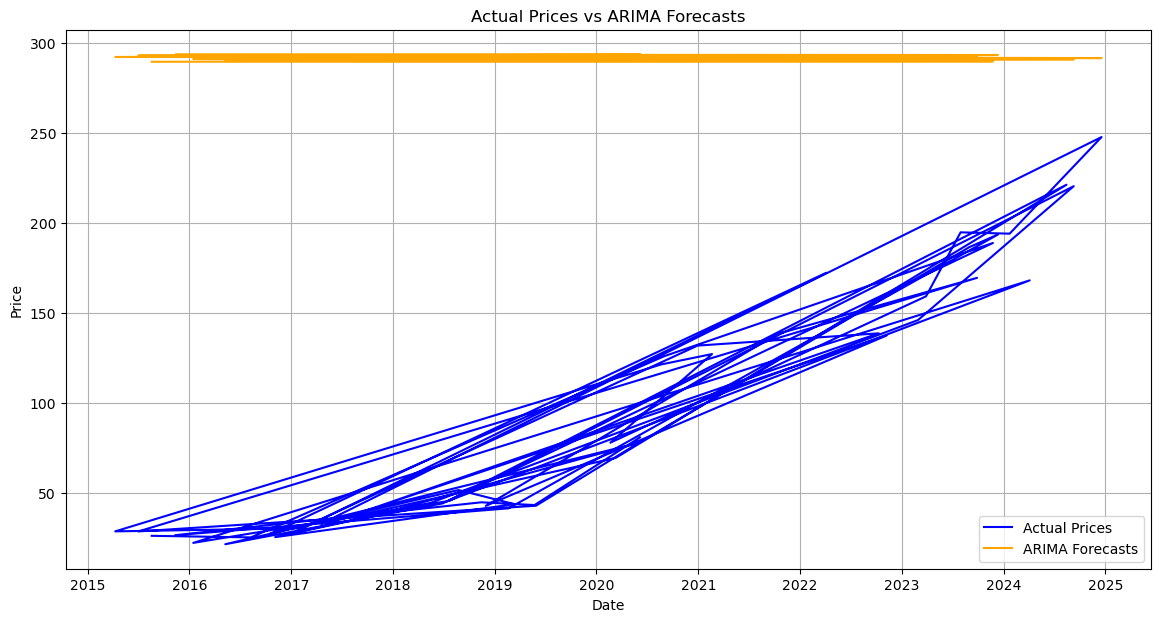

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], arima_forecast_test[-50:], label='ARIMA Forecasts', color='orange')
plt.title('Actual Prices vs ARIMA Forecasts')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

* #### Plotting Actual vs Gradient Boosting Predictions

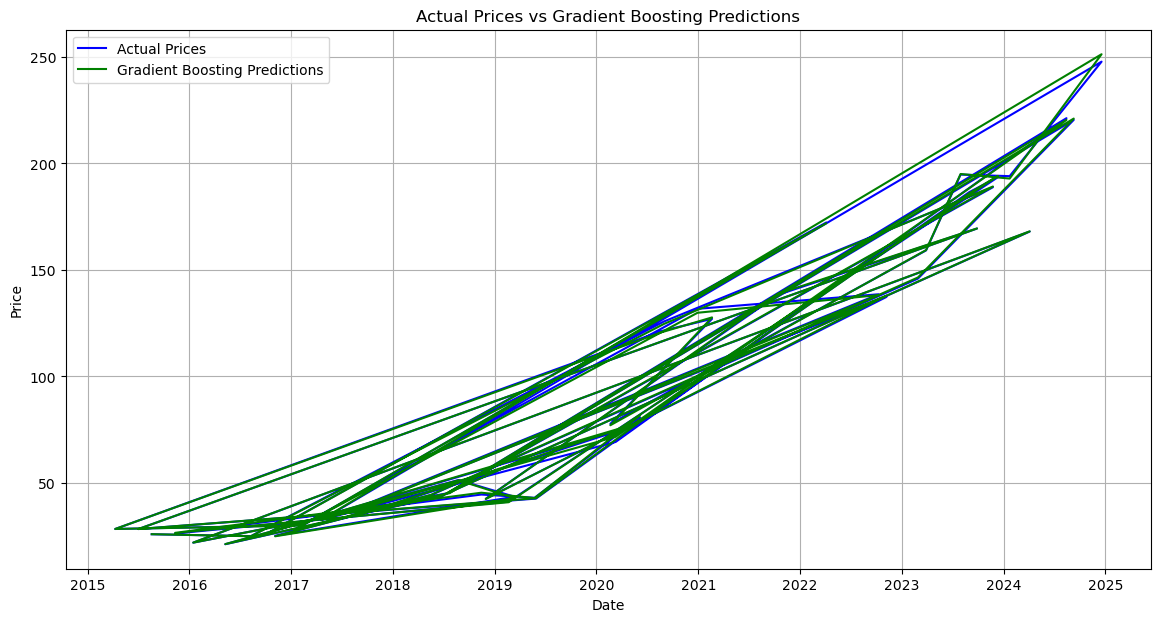

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], y_pred_tuned[-50:], label='Gradient Boosting Predictions', color='green')
plt.title('Actual Prices vs Gradient Boosting Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Step 6: Conclusions and Recommendations
* ARIMA Model: Suitable for time-dependent patterns and short-term trend predictions.

* Gradient Boosting Model: Performs well with engineered features, handling sudden fluctuations effectively.

#### Recommendations:

* Combine both models for hybrid predictions.

* Use ARIMA for stable trends and Gradient Boosting for capturing non-linear relationships.